In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer

import matplotlib.pyplot as plt
import numpy as np
import math
import random
import os

In [3]:
#Data creation
class Generator:

    def __init__(self):
        self.upper = 10
        self.combo_list = []
        self.__execute_computing()

    def __execute_computing(self):
        for a in range(0,self.upper):
            for b in range(0,self.upper):
                for c_in in range(0,2):
                    c_out = 1 if a+b+c_in>=10 else 0
                    y = a+b+c_in if a+b+c_in<10 else a+b+c_in-10
                    self.combo_list.append([a, b, c_in, y, c_out])

In [4]:
class DataCreator:
    def __init__(self):
        obj_gen = Generator()
        self.array_gen = np.array(obj_gen.combo_list)
        print(self.array_gen.shape)
    def __call__(self):
      return self.array_gen[:,:3], self.array_gen[:,3].reshape((-1,1)), self.array_gen[:,4].reshape((-1,1))


X_train, S_train, C_train = DataCreator()()

(200, 5)


In [5]:
print(f"X set shape: {X_train.shape}")
print(f"Y set shape: {S_train.shape}")
print(f"C set shape: {C_train.shape}")

X set shape: (200, 3)
Y set shape: (200, 1)
C set shape: (200, 1)


In [6]:
#Verify that random sums are correct
for _ in range(5):
  index = random.randint(0,X_train.shape[0])
  print(f"These numbers summed: {X_train[index]} give S: {S_train[index]} and Cout: {C_train[index]}\n")

These numbers summed: [8 6 1] give S: [5] and Cout: [1]

These numbers summed: [4 5 0] give S: [9] and Cout: [0]

These numbers summed: [3 1 1] give S: [5] and Cout: [0]

These numbers summed: [8 8 0] give S: [6] and Cout: [1]

These numbers summed: [6 8 0] give S: [4] and Cout: [1]



In [7]:
#model creation with functional API
class BaseLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.dense0 = tf.keras.layers.Dense(32, activation='relu',
                                            input_shape=(None,3),
                                            kernel_regularizer=tf.keras.regularizers.L2(0.01),
                                            kernel_initializer='he_normal')
        self.dense1 = tf.keras.layers.Dense(32, activation='relu',
                                            kernel_regularizer=tf.keras.regularizers.L2(0.01),
                                            kernel_initializer='he_normal')
    def call(self, inputs):
        x0 = inputs
        x1 = self.dense0(x0)
        return self.dense1(x1)

class OutputLayers(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.cout = tf.keras.layers.Dense(1, activation='sigmoid',
                                          kernel_initializer='he_normal')
        self.sum0 = tf.keras.layers.Dense(32, activation='relu',
                                          kernel_initializer='he_normal')
        self.sum1 = tf.keras.layers.Dense(10, activation=None,
                                          kernel_initializer='he_normal')
    def call(self, inputs):
        x0 = inputs
        x1 = self.sum0(x0)
        return self.cout(x0), self.sum1(x1)

In [8]:
class Branch_Net(tf.keras.Model):
    def __init__(self):
        super(Branch_Net, self).__init__()
        self.base = BaseLayer()
        self.out = OutputLayers()

    def call(self, inputs):
        x0 = inputs
        x1 = self.base(x0)
        self.out2 = self.out(x1)
        return self.out2

In [20]:
class EarlyStop(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('output_1_accuracy') is not None and \
        logs.get('output_1_accuracy') == 1.0 and \
        logs.get('output_2_accuracy') is not None and \
        logs.get('output_2_accuracy') == 1.0:
            print("\nReached wanted accuracy so cancelling training!")
            self.model.stop_training = True
early_stop_cb = EarlyStop()

In [21]:
#Placing and Compiling Model
model = Branch_Net()

In [22]:
epochs=[2000, 300, 300, 300]
learning_rate = [2e-3, 8e-4, 2e-4, 5e-5]
history = []
for epoch, lr in zip(epochs, learning_rate):
    model.compile(
            loss={'output_1': 'binary_crossentropy',
                  'output_2': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)},
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            metrics={'output_1':'accuracy',
                     'output_2': 'accuracy'})

    history.append(model.fit(
          X_train, (C_train, S_train),
          epochs=epoch,
          batch_size=4,
          verbose=1,
          callbacks=[early_stop_cb]))


Epoch 1/2000
50/50 [==============================] - 1s 3ms/step - loss: 5.9325 - output_1_loss: 1.0001 - output_2_loss: 3.7878 - output_1_accuracy: 0.5700 - output_2_accuracy: 0.0700
Epoch 2/2000
50/50 [==============================] - 0s 3ms/step - loss: 4.1543 - output_1_loss: 0.5534 - output_2_loss: 2.6015 - output_1_accuracy: 0.6850 - output_2_accuracy: 0.0650
Epoch 3/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.8810 - output_1_loss: 0.5121 - output_2_loss: 2.4645 - output_1_accuracy: 0.7550 - output_2_accuracy: 0.1050
Epoch 4/2000
50/50 [==============================] - 0s 3ms/step - loss: 3.8287 - output_1_loss: 0.4979 - output_2_loss: 2.4929 - output_1_accuracy: 0.7550 - output_2_accuracy: 0.0750
Epoch 5/2000
50/50 [==============================] - 0s 3ms/step - loss: 3.7230 - output_1_loss: 0.4887 - output_2_loss: 2.4467 - output_1_accuracy: 0.7700 - output_2_accuracy: 0.0950
Epoch 6/2000
50/50 [==============================] - 0s 3ms/step - loss: 3

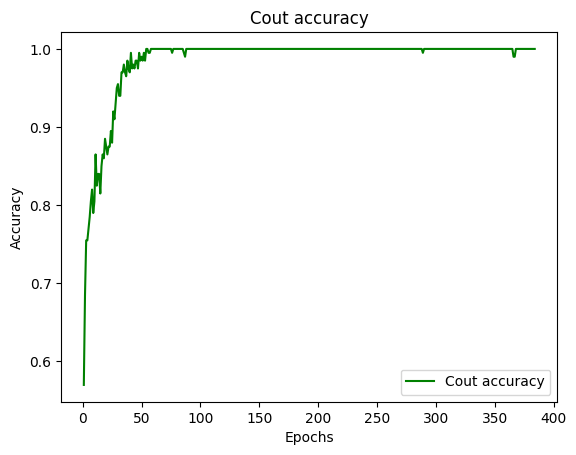

In [25]:
out1_accuracy = history[0].history['output_1_accuracy']


epochs = range(1,history[0].epoch[-1]+2)
plt.plot(epochs, out1_accuracy, 'g', label='Cout accuracy')

plt.title('Cout accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

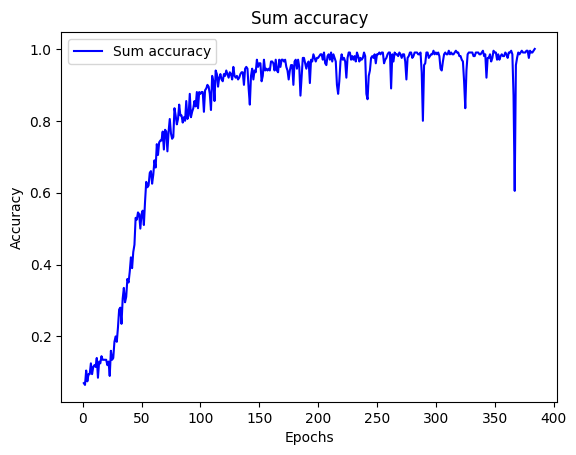

In [26]:
out2_accuracy = history[0].history['output_2_accuracy']
plt.plot(epochs, out2_accuracy, 'b', label='Sum accuracy')
plt.title('Sum accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [59]:
def number_equalizer(A: str, B: str):
    if(len(A) > len(B)):
        B = B.zfill(len(A))
    else:
        A = A.zfill(len(B))
    return A, B

In [75]:
SUM = ""
starting=True
Cout = 0

A='55998789797999779099999999876559898987878776656375009082580295555'
B='82580299999987877665637509987655709055555789797999779099989898985'

A_n, B_n = number_equalizer(A, B)


for (ai, bi) in zip(A_n[::-1], B_n[::-1]):
    if(starting):
        starting = False
        evaluation = model.predict([[int(ai),int(bi),Cout]],verbose = 0)
        SUM = str(np.argmax(evaluation[1][0])) + SUM
    else:
        evaluation = model.predict([[int(ai),int(bi),Cout]],verbose = 0)
        sum = np.argmax(evaluation[1][0])
        SUM = str(np.argmax(evaluation[1][0])) + SUM
    Cout = 1 if evaluation[0][0][0] > 0.98 else 0
if(Cout == 1):
    SUM = f"{Cout}" + SUM
if(Cout == 1) :
    print(f" {A} + \n {B} = \n{SUM}")
else:
    print(f"{A} + \n{B} = \n{SUM}")

 55998789797999779099999999876559898987878776656375009082580295555 + 
 82580299999987877665637509987655709055555789797999779099989898985 = 
138579089797987656765637509864215608043434566454374788182570194540
